In [2]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
with zipfile.ZipFile("/content/drive/MyDrive/Colab_Notebooks/data/sii_data/lab_4/miem-hse-ais-2023-lab-04.zip","r") as zip_ref:
    zip_ref.extractall("./")

In [100]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import mobilenet_v2
from torchvision.transforms import transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
from PIL import Image

In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [159]:
class MyDataset(Dataset):
    def __init__(self, path, names, words, labels=None, transform=None, is_test=False, csv=None):
        self.names = names
        self.words = words
        self.labels = labels
        self.path = path
        self.transform = transform
        self.is_test = is_test
        self.data = pd.read_csv(csv)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        if self.is_test:
            waveform, sr = librosa.load(self.path + '/' + self.data.loc[index, 'id'])
            label = self.data.loc[index, 'answer']
        else:
            waveform, sr = librosa.load(f"{self.path}/{self.words[index]}/{self.names[index]}")
            label = self.labels[index]

        n_fft, step = 1024, 1024 // 4
        mel_spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft, hop_length=step), ref=np.max)
        mel_spectrogram = np.round(mel_spectrogram)
        mel_spectrogram = to_pil_image(mel_spectrogram)

        if self.transform is not None:
            mel_spectrogram = self.transform(mel_spectrogram)

        if self.labels is not None:
            return mel_spectrogram, label
        else:
            return mel_spectrogram

In [160]:
def transformation(sounds_path, is_test=False):
    sounds_path = sorted(glob.glob(sounds_path))

    names, words, labels = [], [], []

    for path in sounds_path:
        if is_test:
            word = 'test'
            name = os.path.basename(path)
        else:
            word = os.path.basename(os.path.dirname(path))
            name = os.path.basename(path)
        words.append(word)
        names.append(name)

    if not is_test:
        for word in words:
            labels.append(word)

        label_dict = {'house': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'stop': 7, 'cat': 8, 'dog': 9}
        labels = [label_dict[label] for label in labels]

    return names, words, labels

In [161]:
def train(model, device, train_loader, optimizer, epoch):
    loss_func = CrossEntropyLoss()
    model.train()
    total_loss = 0.0

    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data = data.repeat(1, 3, 1, 1).to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    return total_loss / len(train_loader)

def valid(model, device, valid_loader):
    print("Validation")
    loss_func = CrossEntropyLoss()
    model.eval()
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(valid_loader):
            data = data.repeat(1, 3, 1, 1).to(device)
            target = target.to(device)

            output = model(data)
            loss = loss_func(output, target)
            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(valid_loader.dataset)
    accuracy = correct / len(valid_loader.dataset) * 100.0

    return total_loss, accuracy


def test(model, device, test_loader):
    print("Test")
    model.eval()
    overall_output = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            data = data.repeat(1, 3, 1, 1).to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            overall_output += list(pred.cpu().numpy()[:, 0])
    return overall_output

In [162]:
def fit(model, train_loader, valid_loader, optimizer, scheduler, device, epochs):
    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        valid_loss, accuracy = valid(model, device, valid_loader)

        print(f'Epoch {epoch}/{epochs} -> Train Loss: {train_loss:.6f} | Valid Loss: {valid_loss:.6f} | Accuracy: {accuracy:.2f}%')

        scheduler.step()

In [163]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [166]:
train_names, train_words, train_labels = transformation('train/*/*.wav')
test_names, _, _ = transformation('test/*.wav', is_test=True)

train_dataset = MyDataset(path='train', names=train_names, words=train_words, labels=train_labels, transform=transform, csv='sample_submission.csv')

In [167]:
train_size = int(0.9 * len(train_dataset))
train_dataset, valid_dataset = random_split(train_dataset, [train_size, len(train_dataset) - train_size])

test_dataset = MyDataset(path='test', names=test_names, words=test_names, labels=None, transform=transform, is_test=True, csv='sample_submission.csv')

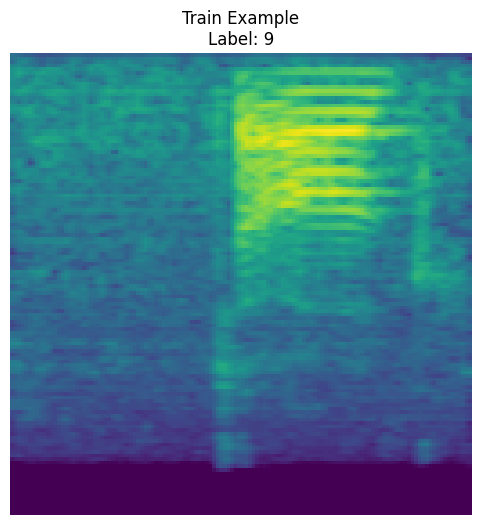

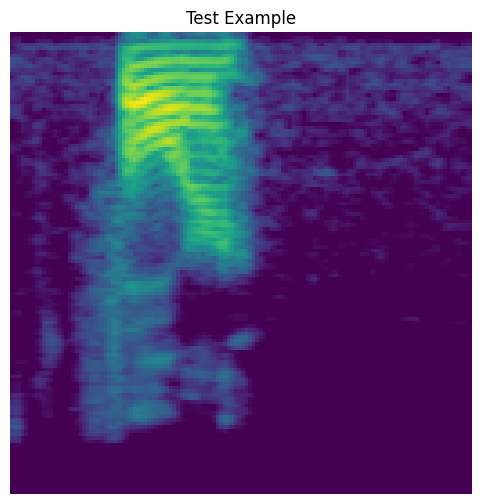

In [168]:
import matplotlib.pyplot as plt

train_example = train_dataset[0][0]
train_label = train_dataset[0][1]

plt.figure(figsize=(6, 6))
plt.title(f"Train Example\nLabel: {train_label}")
plt.imshow(train_example.squeeze(), cmap='viridis')
plt.axis('off')
plt.show()

test_example = test_dataset[0]

plt.figure(figsize=(6, 6))
plt.title("Test Example")
plt.imshow(test_example.squeeze(), cmap='viridis')
plt.axis('off')
plt.show()

In [169]:
batch_size = 128

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [170]:
epochs = 2


model = mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.6)



fit(model, train_loader, valid_loader, optimizer, scheduler, device, epochs)


torch.save(model.state_dict(), "my_model.pt")


output = test(model, device, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
1it [00:01,  1.28s/it]

Train Epoch: 1 [0/11832 (0%)]	Loss: 2.405079


21it [00:32,  1.67s/it]

Train Epoch: 1 [2560/11832 (22%)]	Loss: 0.237910


41it [01:08,  1.41s/it]

Train Epoch: 1 [5120/11832 (43%)]	Loss: 0.166412


61it [01:40,  1.39s/it]

Train Epoch: 1 [7680/11832 (65%)]	Loss: 0.152414


81it [02:10,  1.44s/it]

Train Epoch: 1 [10240/11832 (86%)]	Loss: 0.052803


93it [02:29,  1.60s/it]


Validation


100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Epoch 1/2 -> Train Loss: 0.364083 | Valid Loss: 0.001636 | Accuracy: 92.93%


1it [00:01,  1.25s/it]

Train Epoch: 2 [0/11832 (0%)]	Loss: 0.130389


21it [00:31,  1.43s/it]

Train Epoch: 2 [2560/11832 (22%)]	Loss: 0.039911


41it [01:03,  1.67s/it]

Train Epoch: 2 [5120/11832 (43%)]	Loss: 0.074880


61it [01:33,  1.68s/it]

Train Epoch: 2 [7680/11832 (65%)]	Loss: 0.011497


81it [02:02,  1.50s/it]

Train Epoch: 2 [10240/11832 (86%)]	Loss: 0.092158


93it [02:19,  1.50s/it]


Validation


100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


Epoch 2/2 -> Train Loss: 0.067832 | Valid Loss: 0.000725 | Accuracy: 97.26%
Test


100%|██████████| 71/71 [01:41<00:00,  1.43s/it]


In [172]:
label_mapping = {0: 'house', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'stop', 8: 'cat', 9: 'dog'}
output_words = [label_mapping[int(label)] for label in output]

sam_sub = pd.read_csv('sample_submission.csv')
submission = pd.DataFrame(sam_sub['id'], columns=['id'])
submission['answer'] = output_words
submission.to_csv('gorbuntsov_result.csv', index=False)